# KORONAVIRUS

U jeku nove epidemije na≈°e su misli cijeli dan, svaki dan, usmjerene na nove vijesti o stanju u dr≈æavi i svijetu, broju zara≈æenih, oporavljenih i preminulih od nove bolesti. Buduƒái da su svi ti podatci danas lako dostupni (a medicina je iznimno zanimljiva za prouƒçavanje s matematiƒçke toƒçke gledi≈°ta), u ovom ƒáemo radu promatrati i analizirati te podatke.

## ≈†to je koronavirus?

Par ƒçinjenica unijeti, ne previ≈°e, ali ipak da znamo ≈°to je.

## Analiza podataka

Podatci su preuzeti sa stranice https://data.europa.eu/euodp/hr/data/dataset/covid-19-coronavirus-data i spremljeni u datoteku imena (zasad) `preuzmi.csv`. <br><br>
Podatci u tablici su sljedeƒái:<br><br>
```
    1. dateRep = promatrani datum u formatu 'dd/mm/gggg'
    2. day = broj dana u promatranom datumu
    3. month = broj mjeseca u promatranom datumu
    4. year = broj godine u promatranom datumu
    5. cases = broj novozara≈æenih na promatrani dan
    5. deaths = broj preminulih na promatrani dan
    6. countriesAndTerritories = naziv dr≈æave
    7. geoId = iso kod dr≈æave (alpha 2)
    8. countryterritoryCode = iso kod dr≈æave (alpha 3)
    9. popData2018 = ukupan broj populacije iz 2018. za promatranu dr≈æavu
```
<br>
Prije nego ≈°to krenemo prikazivati tablice i analizirati podatke, prvo ≈æelimo tablicu <i>srediti</i>. Vidimo odmah da u ovoj tablici ima redundancija (datumi) i nama nebitnih podataka (iso kodovi) pa ƒáemo prije svega ukljuƒçiti potrebne biblioteke i rije≈°iti se tih problema (pa usto i preimenovati preostajeƒáe podatke u ne≈°to <i>ljep≈°e</i>).

In [1]:
import numpy as np
import pandas as pd
import requests

url = 'https://opendata.ecdc.europa.eu/covid19/casedistribution/csv'
file = requests.get(url)
open('podatci.csv', 'wb').write(file.content)
data = pd.read_csv('podatci.csv', encoding='utf-8')
data = data.rename(columns={'dateRep': 'Date', 'cases': 'Cases', 'deaths': 'Deaths', 'countriesAndTerritories': 'Country', 'popData2018': 'Population'})
data['Date'] = pd.to_datetime(dict(year=data['year'], month=data['month'], day=data['day']))
del data['day'], data['month'], data['year'], data['geoId'], data['countryterritoryCode']
data = data[::-1]

data.head()

Date  Cases  Deaths continentExp  Population   Country
11980 2020-03-21      1       0       Africa  14439018.0  Zimbabwe
11979 2020-03-22      1       0       Africa  14439018.0  Zimbabwe
11978 2020-03-23      0       0       Africa  14439018.0  Zimbabwe
11977 2020-03-24      0       1       Africa  14439018.0  Zimbabwe
11976 2020-03-25      0       0       Africa  14439018.0  Zimbabwe

Sad mo≈æemo pogledati grafiƒçki prikaz razvoja epidemije.<br>
Na sljedeƒáem grafiƒçkom prikazu vidimo kretanje broja zara≈æenih i preminulih, u linearnoj i logaritamskoj skali.<br>
Ipak, koliko god su nam grafovi u linearnoj skali <i>ugodni oku</i>, graf u logaritamskoj skali nam daje jo≈° malo bolji uvid u razliƒçite brzine rasta:

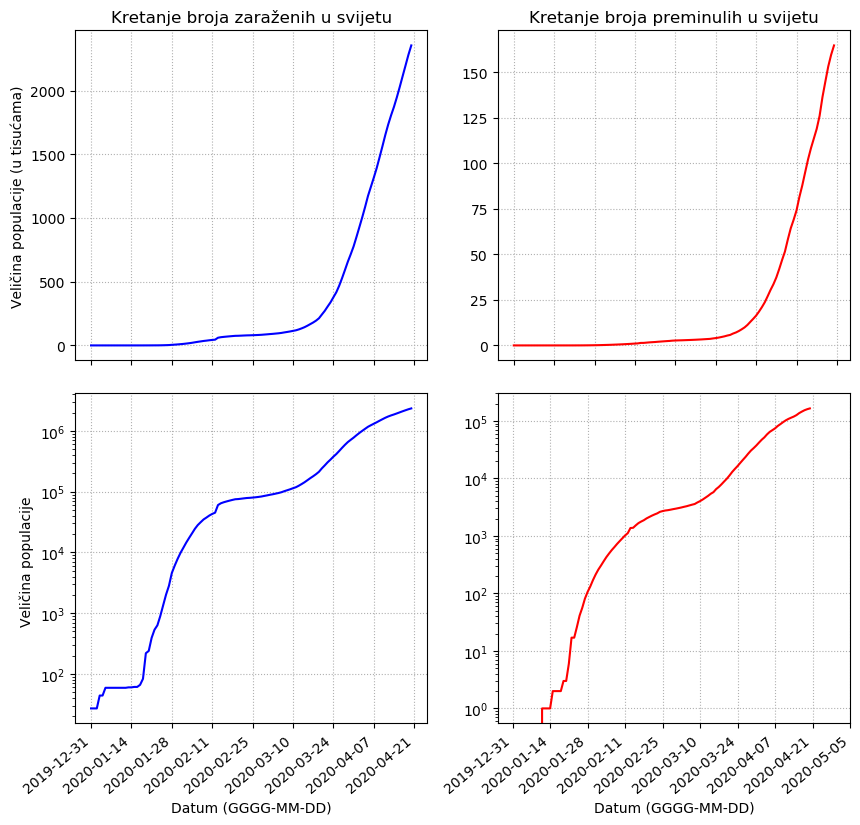

In [55]:
import datetime as dt
from functools import lru_cache
import matplotlib.pyplot as plt
plt.rcParams['figure.max_open_warning'] = 250
%matplotlib agg

@lru_cache()
def izdvoji_dr≈æavu(dr≈æava):
    if dr≈æava == 'World': return izdvoji_dr≈æavu('China')
    return data[data['Country'] == dr≈æava]

def ukupno_dnevno_stanje(argument):
    lista=[]
    suma = 0
    for broj in data.groupby(['Date']).sum()[argument]:
        suma += broj
        lista.append(suma)
    return lista

def lista_dnevno_stanje(dr≈æava, argument):
    if dr≈æava == 'World': return ukupno_dnevno_stanje(argument)
    lista = []
    i=-1
    for dnevno_stanje in np.array(izdvoji_dr≈æavu(dr≈æava)[argument]):
        if i==-1: lista.append(int(dnevno_stanje))
        else: lista.append(int(dnevno_stanje)+lista[i])
        i +=1
    return lista

pridjevi = {'Cases': 'zara≈æeni', 'Deaths':'preminuli', 0:'Cases', 1:'Deaths'}
skale = {0:'linear', 1:'log'}
boje = {0:'blue', 1:'red'}
jedinica = {0:1000, 1:1, 2:'(u tisuƒáama)', 3: ''}
dr≈æave = {dr≈æava:'dr≈æavi: \n'+ dr≈æava.replace('_', ' ') for dr≈æava in data['Country'].drop_duplicates()}
dr≈æave['World'] = 'svijetu'

def prikaz_kontinuiranog_stanja(dr≈æava):
    #n = (dt.datetime(2020, 4, 17)-dt.datetime(2019, 12, 31)).days
    #base =dt.datetime(2019, 12, 31)
    dates = np.array(izdvoji_dr≈æavu(dr≈æava)['Date'])
    k = 0
    for broj in izdvoji_dr≈æavu(dr≈æava)['Cases']: 
        if broj == 0: k += 1
        else: break
    if k > 2: k -= 2
    n = dates[k:].shape[0]//8
    base = dates[k]
    dates2 = np.array([base + np.timedelta64(i*n, 'D') for i in range (0, 10)])
    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, squeeze=True, figsize=(10, 9), gridspec_kw=dict(hspace=0.1))
    plt.xticks(rotation=40, ha='right')
    for i in range (0, 2):
        for j in range (0, 2):
            ax[i][j].plot(dates[k:], np.array(lista_dnevno_stanje(dr≈æava, pridjevi[j]))[k:]/jedinica[i], color=boje[j])     
            ax[0][j].set_title('Kretanje broja ' + pridjevi[pridjevi[j]] + 'h u ' + dr≈æave[dr≈æava], fontsize='large')
            ax[i][0].set_ylabel('Veliƒçina populacije ' + jedinica[i+2])
            ax[1][j].set_xlabel('Datum (GGGG-MM-DD)', fontsize='medium')
            ax[i][j].set_yscale(skale[i])
            plt.setp( ax[i][j].xaxis.get_majorticklabels(), rotation=40, ha='right')
            ax[i][j].set_xticks(dates2)
            ax[i][j].grid(linestyle = ':')
    return fig

prikaz_kontinuiranog_stanja('World')

Ovako napisanu prethodnu funkciju mo≈æemo korsititi i da bismo prikazali podatke u svakoj pojedinoj dr≈æavi.<br>
Pogledajmo stoga, na primjer, podatke u Italiji (ovdje iz donjih grafova, koji su u logaritamskoj skali, jasnije uoƒçavamo kako se brzina rasta broja oboljelih i preminulih doista smanjuje, dok nam linearna skala to ne predoƒçava toliko jasno):

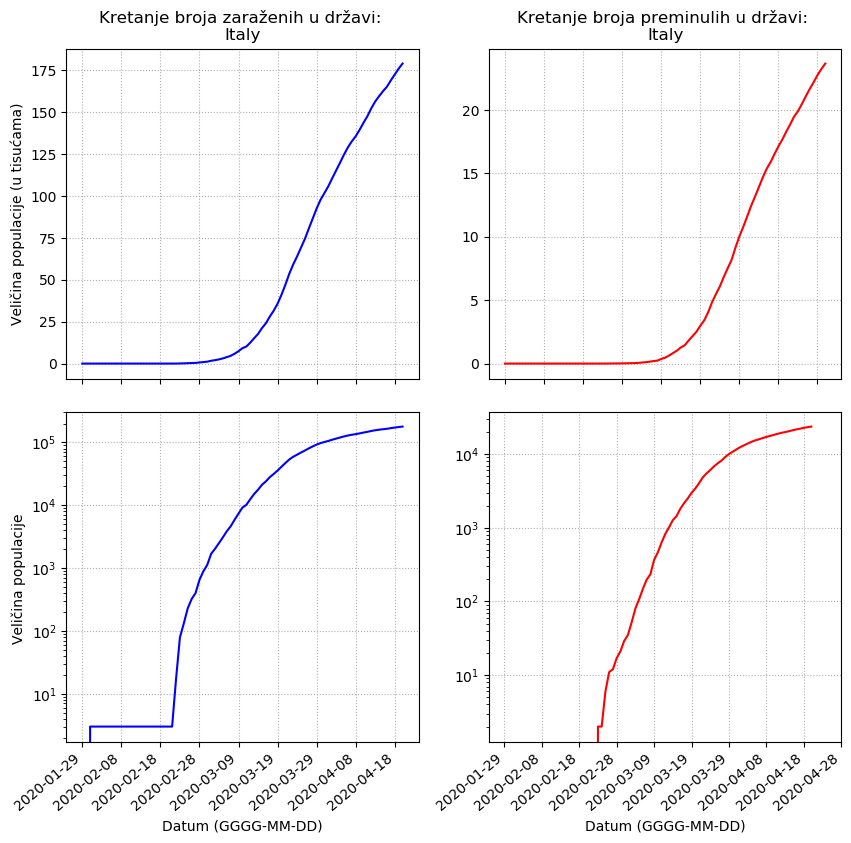

In [3]:
prikaz_kontinuiranog_stanja('Italy')

U medijima svakodnevno nailazimo na <i>usporedbe</i> stanja epidemije u razliƒçitim dr≈æavama. Kao matematiƒçari, mi ipak znamo da ovakve usporedbe imaju smisla jedino kada usporeƒëujemo udio broja zara≈æenih u ukupnoj populaciji. Idealno bi takoƒëer bilo gledati koliki je udio preminulih u ukupnom broju zatvorenih sluƒçajeva; meƒëutim, podatci o broju ozdravljenih po svakoj dr≈æavi zasebno nam nisu ovako dostupni kao i ostali podatci, pa ƒáemo takoƒëer promatrati udio preminulih osoba u ukupnoj populaciji.

In [4]:
def pripremi_podatke(dr≈æava, argument):
    dates = np.array(izdvoji_dr≈æavu(dr≈æava)['Date'])
    n = dates.shape[0]//10
    base = dates[0]
    dates2 = np.array([base + np.timedelta64(i*n, 'D') for i in range (0, 12)])
    return [dates, dates2]
#jo≈° jedna pomoƒána funkcija za bolju organizaciju podataka

def usporedba(lista):
    brojevi = np.array([izdvoji_dr≈æavu(dr≈æava)[izdvoji_dr≈æavu(dr≈æava)['Cases']>=0].shape[0] for dr≈æava in lista])
    broj = brojevi.max()
    k = 0
    for temp in brojevi:
        if broj == temp: break;
        k += 1
    fig, ax = plt.subplots(1, 2, sharex=True, squeeze=True, figsize=(10, 5), gridspec_kw=dict(hspace=0.1))
    for i in range (0, 2):
        datumi = pripremi_podatke(lista[k], pridjevi[i])
        duljina = datumi[0].shape[0]
        for dr≈æava in lista:
            nova = lista_dnevno_stanje(dr≈æava, pridjevi[i])[::-1]
            while len(nova) < duljina: nova.append(0)
            ax[i].plot(datumi[0], nova[::-1]/(np.array(izdvoji_dr≈æavu(dr≈æava)['Population'])[0]/100), label = dr≈æava.replace('_', ' '))
            #ax[i][j].plot(dates[k:], np.array(lista_dnevno_stanje(dr≈æava, pridjevi[j]))[k:]/jedinica[i], color=boje[j])     
            ax[i].set_title('Usporedba kretanja broja ' + pridjevi[pridjevi[i]] + 'h', fontsize='large')
            ax[i].set_xlabel('Datum (GGGG-MM-DD)', fontsize='medium')
            plt.setp( ax[i].xaxis.get_majorticklabels(), rotation=40, ha='right')
            ax[i].set_xticks(datumi[1])
            ax[i].grid(linestyle = ':')
    ax[0].set_ylabel('Udio zara≈æenih (%)')
    ax[0].legend(loc = 'best')  
    return fig

Stoga prvo pogledajmo usporedbu izmeƒëu Hrvatske i nekih susjeda (Italiju ƒáemo ostaviti za kasnije). Da se razumijemo, poanta ovog dijela rada nije da epidemiju tretiramo kao 'natjecanje', veƒá da iznesemo toƒçne podatke i ih interpretiramo na ispravan (matematiƒçki) naƒçin. Stoga je jedina sigurnost koju u ovome grafu mo≈æemo vidjeti jest da izmeƒëu broje zara≈æenih i broja preminulih ne postoji neka jasna veza, jer iako Hrvatska ima najmanji broj preminulih, nema i najmanji broj oboljelih (<i>19. travnja</i>).<br><br>
<b>Va≈æna napomena:</b><br>
Ja mogu interpretirati samo dio ovih podataka, jer se brojevi, to jest tijek epidemije, u dr≈æavi, Europi i svijetu mijenja iz dana u dan. Podatci koje ja vidim danas (19. travnja) sigurno neƒáe biti isti u trenutku kada Vi ovo ƒçitate. Stoga ƒáe sve moje interpretacije podataka biti u kratkim crtama (ili s naznaƒçenim datumom ako je prijeko potrebno) a detaljniju analizu ostavljam Vama. üòä

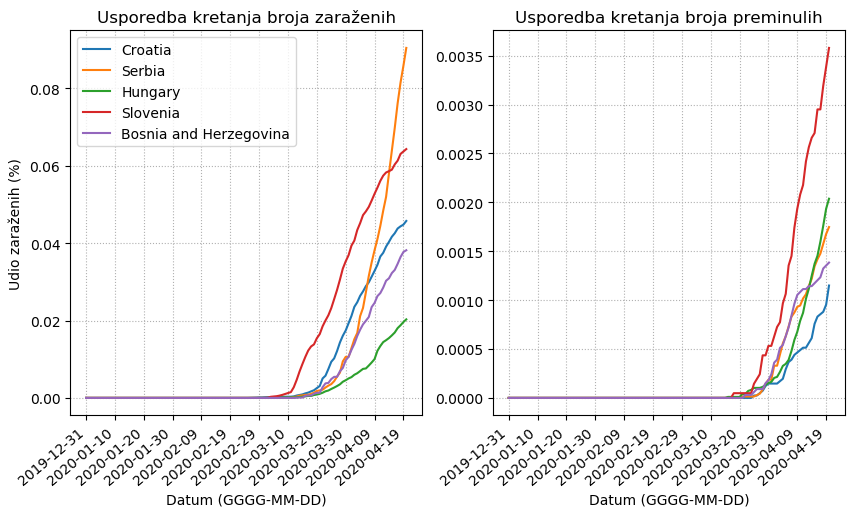

In [5]:
usporedba(['Croatia', 'Serbia', 'Hungary', 'Slovenia', 'Bosnia_and_Herzegovina'])

## Predviƒëanje daljnjeg razvoja epidemije

Naravno, nas ne zanima iskljuƒçivo trenutno stanje, veƒá nas zanima mo≈æemo li <i>predvidjeti</i> daljnji tijek ove epidemije?<br>
Odgovor: <b>linearna regresija</b>.<br><br>
<i>Slijedi poja≈°njenje ≈°to je linearna regresija i metoda najmanjih kvadrata i na koji naƒçin to ovdje koristimo, nadodat ƒáu tekst naknadno...</i><br><br>
Maloƒças navedenom metodom mo≈æemo procijeniti moguƒái tijek epidemije (na primjer, za Hrvatsku): <br><br>
Ovdje imamo dva oƒçita problema kori≈°tenja linearne regresije:
<lu>
    <li>U stvarnosti je rast rijetko gdje doista eksponencijalan, prije svega jer su nadle≈æne vlasti reagirale relativno pravodobno i uƒçile na dosada≈°njim gre≈°kama ostalih nacija (jedan relativno dobar primjer je dakako i Hrvatska).</li>
    <li>Na mjestima gdje rast u poƒçetku i jest eksponencijalan, obiƒçno se on vrlo brzo stavi pod kontrolu pa nam funkcija dobivena ovom metodom vi≈°e puno i ne koristi (npr. trenutno nam nema smisla na ovaj naƒçin prouƒçavati podatke u Kini).</li>
</lu>

In [71]:
import statsmodels.api as sm

def pomoƒáni_ln(broj):
    if broj == 0: return 0
    else: return float(np.log(broj))

lnn = np.vectorize(pomoƒáni_ln, otypes=[np.float])

def vrati_procjenu(a, b):
    return lambda x: (np.e**a)*((np.e**b)**x)

def podatci_graf_regresija(dr≈æava):
    dates = np.array(izdvoji_dr≈æavu(dr≈æava)['Date'])
    broj_dana = 0
    while np.array(izdvoji_dr≈æavu(dr≈æava)[izdvoji_dr≈æavu(dr≈æava)['Date']<=dates[broj_dana]]['Cases']).sum()==0:
        broj_dana += 1
    if broj_dana > 2: broj_dana -= 2
    brojaƒç_dana = [i for i in range(0, dates.shape[0]-broj_dana)]
    brojaƒç_dana2 = sm.add_constant(brojaƒç_dana)
    zaraza = lnn(np.array(lista_dnevno_stanje(dr≈æava, 'Cases'))[broj_dana:])
    model = sm.OLS(zaraza, brojaƒç_dana2)
    rez = model.fit()
    print(rez.summary())
    funkcija = vrati_procjenu(rez.params[0], rez.params[1])
    n = dates[broj_dana:].shape[0]//10
    base = dates[broj_dana]
    dates2 = np.array([base + np.timedelta64(i*n, 'D') for i in range (0, 12)])
    #takoƒëer ne ≈æelimo da nam se prika≈æe apsolutno svaki datum jer je to nepregledno
    fig, ax = plt.subplots()
    ax.plot(dates[broj_dana:], lista_dnevno_stanje(dr≈æava, 'Cases')[broj_dana:], alpha=0.65, lw=2, c='g', label='Pravi brojevi')
    ax.plot(dates[broj_dana:], np.vectorize(funkcija)(brojaƒç_dana), alpha=0.65, c='c', lw=2, label='Procjena')
    plt.xticks(rotation=40, ha='right')
    for spine in ('top', 'right'):
        ax.spines[spine].set_visible(False)
    ax.set_xticks(dates2)
    ax.set_facecolor('#efefef')
    ax.set_title('Stvarni brojevi i dobiveni pomoƒáu OLS u dr≈æavi: ' + dr≈æava.replace('_', ' '))
    ax.set_ylabel('Broj zara≈æenih')
    ax.set_xlabel('Datum (GGGG-MM-DD)')
    ax.legend(loc = 'best')
    ax.grid(b=True, which='major', c='#fdfdfd', lw=2, ls='-')
    return [fig, funkcija]

Primjer kada nam linearna regresija i mo≈æe reƒái kako se podatci mogu dalje kretati jest SAD, jer je rast ondje i dalje eksponencijalan:

In [72]:
podatci_SAD = podatci_graf_regresija('Russia')
funkcija_SAD = podatci_SAD[1]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     772.9
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           7.21e-43
Time:                        22:35:41   Log-Likelihood:                -124.41
No. Observations:                  82   AIC:                             252.8
Df Residuals:                      80   BIC:                             257.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7980      0.244     -7.355      0.0

<i>Slijedi interpretacija dobivenih podataka...</i><br><br>
Pogledajmo i grafiƒçki prikaz stvarnih podataka i dobivenih ovom metodom:

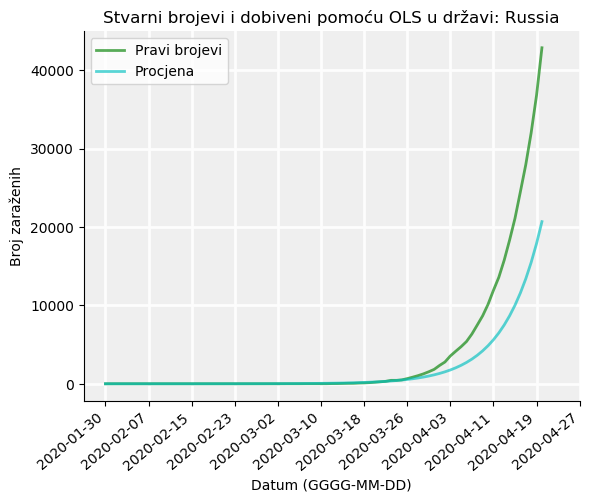

In [73]:
podatci_SAD[0]

Sad mo≈æemo i procijeniti moguƒái broj zara≈æenih na odreƒëeni dan; na primjer, broj zara≈æenih dana 20. travnja 2020. mogao bi biti $1826126$.

In [9]:
int(round(funkcija_SAD((dt.datetime(2020, 4, 20)-dt.datetime(2020, 1, 19)).days)))

101765

Kao ≈°to sam naveo prije, u Hrvatskoj nam ova metoda ne pru≈æa mnogo korisnih podataka jer rast nije eksponencijalan. Jasno vidimo da stoga ovaj rezultat nije egzaktan, pa niti daljnje procjene ne mo≈æemo prihvatiti s nekom pouzdano≈°ƒáu.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     689.1
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           1.14e-31
Time:                        21:24:01   Log-Likelihood:                -52.416
No. Observations:                  54   AIC:                             108.8
Df Residuals:                      52   BIC:                             112.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9642      0.175      5.518      0.0

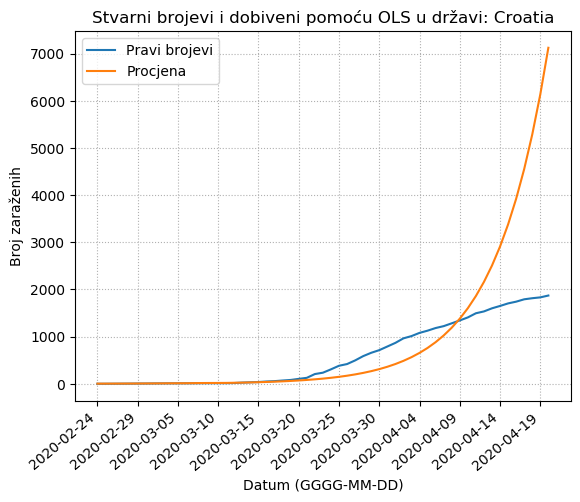

In [10]:
podatci_RH = podatci_graf_regresija('Croatia')
funkcija_RH = podatci_RH[1]
podatci_RH[0]

Za primjer, ova nam procjena ka≈æe da bismo za ≈°est dana, 20. travnja 2020. trebali imati ƒçak $15427$ zara≈æenih, ≈°to je vrlo malo vjerojatan scenarij:

In [11]:
int(round(funkcija_RH((dt.datetime(2020, 4, 20)-dt.datetime(2020, 2, 27)).days)))

7124

## Epidemiolo≈°ki modeli

Ideja za nastavak rada bi bila prouƒçiti relevantne epidemiolo≈°ke modele za infektivne bolesti.<br>
Modeli se temelje na pretpostavci da imamo tri grupe ljudi:<br><br>
<lu>
    <li>oni koji su podlo≈æni bolesti (<i>susceptible</i> - S)</li>
    <li>≈°iritelji zaraze (<i>infectious</i> - I)</li>
    <li>oporavljeni (<i>recovered</i> - R)</li>
</lu><br><br>
Ovisno o moguƒánosti prijelaza imamo dva osnovna modela (koja bismo htjeli promatrati):<br><br>
<lu>
    <li> SIR - moguƒái su prijelazi iz podlo≈ænog bolesti u ≈°iritelj zaraze, te iz ≈°iritelja zaraze u oporavljenog, ali je glavna pretpostavka da se ljudi koji se oporave vi≈°e ne mogu zaraziti</li>
    <li> SIRS - za razliku od SIR modela, ovdje se pretpostavlja da ljudi nakon ≈°to se oporave mogu opet biti podlo≈æni zarazi (nakon izvjesnog vremena)</li>
</lu><br><br>

<i>Konkretne informacije i oznake ovih dvaju modela</i>

<br><br>
U sljedeƒáem grafu imamo vizualizaciju SIR i SIRS modela u ovisnosti o parametrima. Uoƒçimo da je za gama = 0 rijeƒç o SIR modelu, inaƒçe je rijeƒç o SIRS modelu.

In [75]:
from scipy.integrate import odeint
import ipywidgets as widgets

N = 1000
I0, R0 = 1, 0
S0 = N - I0 - R0
beta, gama= 0.2, 1./10
dani = np.linspace(0, 150, 150)

def deriv(y, t, N, beta, gama, sigma):
    S, I, R = y
    dSdt = -beta * S * I / N + sigma * R
    dIdt = beta * S * I / N - gama * I
    dRdt = gama * I - sigma * R
    return dSdt, dIdt, dRdt

def pomoc(sigma):
    y0 = S0, I0, R0
    rez = odeint(deriv, y0, dani, args=(N, beta, gama, sigma))
    S, I, R = rez.T

    fig, ax = plt.subplots()
    ax.plot(dani, S/1000, 'b', alpha=0.65, lw=2, label='Susceptible')
    ax.plot(dani, I/1000, 'r', alpha=0.65, lw=2, label='Infected')
    ax.plot(dani, R/1000, 'g', alpha=0.65, lw=2, label='Recovered with immunity')
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number (1000s)')
    ax.set_ylim(0,1.2)
    ax.set_facecolor('#efefef')
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='#fdfdfd', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right'):
        ax.spines[spine].set_visible(False)
    return fig

k=widgets.interact(pomoc, sigma = widgets.FloatSlider(value=0, min=0, max=0.2, step=0.005))

interactive(children=(FloatSlider(value=0.0, description='sigma', max=0.2, step=0.005), Output()), _dom_classe‚Ä¶

Da bismo dobili stvarnu sliku ovih dvaju modela, prikazat ƒáemo stvarne podatke na podruƒçju Hrvatske. Potrebne podatke sam prikupio i pohranio u datoteku korona_RH.csv.<br><br>
Buduƒái da brzinu prijelaza iz <i>podlo≈ænih zarazi</i> u <i>zara≈æeni</i> i iz <i>zara≈æeni</i> u <i>oporavljeni</i> veƒá imamo, ovdje ƒáemo prikazati podatke u ovisnosti o brzini prijelaza iz <i>oporavljeni</i> u <i>podlo≈æni zarazi</i>. Kada je taj parametar jednak -1, tada pretpostavljamo da svi koji su ozdravljeni imaju imunitet (sukladno SIR modelu, dakako). Inaƒçe su na≈°i podaci malo modificirani, jer pretpostavljamo da se nakon nekog vremena izgubi imunitet.<br><br>
Napomenimo samo da biram podatke prikazati ovako "razdvojeno" jer je rijeƒç o vrlo malim pomacima, to jest mali udio populacije je zara≈æen. Stoga, da prikazujem sve podatke na istom grafu, imali bismo dvije naizgled ravne crte iz kojih ni≈°ta ne bismo mogli zakljuƒçiti.

In [120]:
import copy

data_RH = pd.read_csv('korona_rh.csv')
data_RH['Date'] = pd.to_datetime(dict(year=data_RH['Year'], month=data_RH['Month'], day=data_RH['Day']))
del data_RH['Year'], data_RH['Month'], data_RH['Day']

N=list(izdvoji_dr≈æavu('Croatia')['Population'])[0]

def crtaj_RH_SIRS(trajanje_imuniteta):
    S=[]
    I=[]
    R=[]
    for podatak in data_RH['Cases']:
        S.append(N-podatak)
    I = data_RH['Cases'] - data_RH['Recovered'] - data_RH['Deaths']
    R = copy.deepcopy(data_RH['Recovered'])
    if trajanje_imuniteta != -1:
        for i in range(int(trajanje_imuniteta), len(S)):
            S[i] += R[i-trajanje_imuniteta]
            R[i] -= R[i-trajanje_imuniteta]
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(6, 5), gridspec_kw=dict(hspace=0.2))
    ax[0].plot(data_RH['Date'], S, c='b', label='Podlo≈æni zarazi')
    ax[1].plot(data_RH['Date'], I, c='r', label='Zara≈æeni')
    ax[1].plot(data_RH['Date'], R, c='g', label='Oporavljeni')
    plt.xticks(rotation=40, ha='right')
    for spine in ('top', 'right'):
        ax[0].spines[spine].set_visible(False)
        ax[1].spines[spine].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)
    ax[0].tick_params(axis='x', color='w')
    for i in range(0, 2):
        ax[i].grid(b=True, which='major', c='#fdfdfd', lw=2, ls='-')
        ax[i].set_facecolor('#efefef')
        legend = ax[i].legend(loc='best')
        legend.get_frame().set_alpha(0.5)
    return fig

k=widgets.interact(crtaj_RH_SIRS, trajanje_imuniteta = widgets.FloatSlider(value=-1, min=-1, max=14, step=1))

interactive(children=(FloatSlider(value=-1.0, description='trajanje_imuniteta', max=14.0, min=-1.0, step=1.0),‚Ä¶

<b>NAPOMENE I IDEJE</b>:<br><br>
<lu>
    <li>Paziti da ovo doista bude priƒça, a ne samo crtanje lijepih grafova u raznim bojama!</li>
    <li>Sve dosada≈°nje sekcije nadopuniti konkretnim tekstom i poja≈°njenjima ≈°to se zapravo dogaƒëa i ≈°to radimo.</li>
    <li>Bilo bi zgodno prilagoditi dosada≈°nje funkcije tako da nemamo razdvojeni prikaz broja zara≈æenih i preminulih nego da ta dva grafa budu <i>side-by-side</i>.</li>
    <li>Moguƒánost ubacivanja histograma koji bi prikazivao broj novozara≈æenih po danima.</li>
    <li>Mo≈æda kakav 3D graf? Ili animacija? </li>
    <li>Poseban fokus staviti na Hrvatsku i njezine brojke. Prikupiti dodatne podatke o kretanju broja oporavljenih (tj. stranice koronavirus.hr) i prikazati ih.</li>
    <li>Nadalje razviti sekciju o epidemiolo≈°kim modelima.</li>
    <li>Urediti kod: prilagoditi imena varijabli (da nemamo bilingvalne nazive), rije≈°iti redundancije u kodu (<u>a ima ih</u>) uvoƒëenjem jo≈° nekih pomoƒánih funkcija. </li>
</lu>